# Comparative Analysis of Twitter Ego Networks

This notebook performs a comparative analysis of ego networks with fewer graphs and more comparative tables (saved as CSVs).

In [2]:
# Import Required Libraries
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib
matplotlib.use('Agg')  # non-interactive backend
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load All Twitter Ego Networks

Identify ego networks and load components.

In [3]:
# Define the path to the Twitter ego networks
twitter_path = "twitter_ego/twitter"

# Output folder for summary tables/plots
summary_dir = Path(twitter_path) / "summary_tables"
summary_dir.mkdir(parents=True, exist_ok=True)

# Find all unique node IDs by looking for .edges files
ego_network_ids = []
if os.path.exists(twitter_path):
    for file in os.listdir(twitter_path):
        if file.endswith('.edges'):
            node_id = file.replace('.edges', '')
            ego_network_ids.append(node_id)
    ego_network_ids.sort()
    print(f"Found {len(ego_network_ids)} ego networks")
else:
    print(f"Directory {twitter_path} not found!")

Found 973 ego networks


In [4]:
# Function to load an ego network
def load_ego_network(node_id, twitter_path="twitter_ego/twitter"):
    data = {}
    edges_file = f"{twitter_path}/{node_id}.edges"
    if os.path.exists(edges_file):
        try:
            data['edges'] = pd.read_csv(edges_file, sep=r"\s+", header=None, names=['source','target'], engine='python')
        except Exception:
            data['edges'] = pd.read_csv(edges_file, sep=' ', header=None, names=['source','target'])
    else:
        data['edges'] = pd.DataFrame(columns=['source','target'])
    
    feat_file = f"{twitter_path}/{node_id}.feat"
    if os.path.exists(feat_file):
        data['feat'] = pd.read_csv(feat_file, sep=r"\s+", header=None, engine='python')
    else:
        data['feat'] = None
    
    egofeat_file = f"{twitter_path}/{node_id}.egofeat"
    if os.path.exists(egofeat_file):
        data['egofeat'] = pd.read_csv(egofeat_file, sep=r"\s+", header=None, engine='python')
    else:
        data['egofeat'] = None
    
    circles_file = f"{twitter_path}/{node_id}.circles"
    circles = {}
    if os.path.exists(circles_file):
        with open(circles_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                circles[parts[0]] = parts[1:] if len(parts) > 1 else []
    data['circles'] = circles
    return data

# Load all ego networks (small log)
all_networks = {}
for node_id in ego_network_ids:
    all_networks[node_id] = load_ego_network(node_id, twitter_path=twitter_path)
    print(f"Loaded network {node_id}: {len(all_networks[node_id]['edges'])} edges, {len(all_networks[node_id]['circles'])} circles")

Loaded network 100318079: 8354 edges, 4 circles
Loaded network 10146102: 951 edges, 1 circles
Loaded network 101859065: 208 edges, 4 circles
Loaded network 101903164: 51 edges, 2 circles
Loaded network 102765423: 1070 edges, 3 circles
Loaded network 102903198: 4925 edges, 1 circles
Loaded network 103431502: 473 edges, 2 circles
Loaded network 103865085: 2484 edges, 2 circles
Loaded network 103991905: 615 edges, 2 circles
Loaded network 104324908: 77 edges, 2 circles
Loaded network 104615636: 506 edges, 3 circles
Loaded network 1046661: 1642 edges, 7 circles
Loaded network 104991493: 2419 edges, 5 circles
Loaded network 105150583: 4795 edges, 5 circles
Loaded network 105398724: 166 edges, 2 circles
Loaded network 105918870: 2849 edges, 7 circles
Loaded network 107172099: 285 edges, 2 circles
Loaded network 107418464: 1739 edges, 2 circles
Loaded network 107511013: 294 edges, 0 circles
Loaded network 107512718: 2322 edges, 17 circles
Loaded network 107516840: 7160 edges, 5 circles
Loaded

## 2. Build Graphs and Extract Basic Stats

Construct NetworkX graphs and compute basic statistics; save as CSVs.

In [5]:
# Build graphs
def build_ego_graph(node_id, network_data):
    G = nx.DiGraph()
    edges = network_data.get('edges', pd.DataFrame(columns=['source','target']))
    if not edges.empty:
        G.add_edges_from(edges.values)
    G.add_node(node_id)
    neighbors = set()
    if not edges.empty:
        neighbors = set(edges['source'].tolist()) | set(edges['target'].tolist())
    for n in neighbors:
        G.add_edge(node_id, n)
    return G

graphs = {}
for node_id, network_data in all_networks.items():
    graphs[node_id] = build_ego_graph(node_id, network_data)

# Compute basic stats
def compute_basic_stats(G):
    stats = {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'is_connected': nx.is_weakly_connected(G) if G.number_of_nodes()>0 else False,
    }
    try:
        stats['num_scc'] = nx.number_strongly_connected_components(G)
        stats['num_wcc'] = nx.number_weakly_connected_components(G)
    except Exception:
        stats['num_scc'] = 0
        stats['num_wcc'] = 0
    return stats

network_stats = {nid: compute_basic_stats(G) for nid, G in graphs.items()}
stats_df = pd.DataFrame(network_stats).T
stats_df.index.name = 'network_id'
print('Basic Network Statistics (first rows):')
display(stats_df.head())
# Save
stats_df.to_csv(summary_dir / 'basic_stats.csv')

Basic Network Statistics (first rows):


,num_nodes,num_edges,density,is_connected,num_scc,num_wcc
network_id,,,,,,
100318079,221,8574,0.176347,True,4,1
10146102,96,1046,0.114693,True,12,1
101859065,24,231,0.418478,True,3,1
101903164,15,65,0.309524,True,4,1
102765423,85,1154,0.161625,True,9,1


## 3. Degree Statistics (tables)

Compute degree statistics for each network and save results.

In [6]:
# Compute degree statistics
def compute_degree_stats(G):
    in_degrees = [d for _, d in G.in_degree()]
    out_degrees = [d for _, d in G.out_degree()]
    if len(in_degrees)==0: in_degrees=[0]
    if len(out_degrees)==0: out_degrees=[0]
    stats = {
        'mean_in_degree': float(np.mean(in_degrees)),
        'median_in_degree': float(np.median(in_degrees)),
        'max_in_degree': int(np.max(in_degrees)),
        'std_in_degree': float(np.std(in_degrees)),
        'mean_out_degree': float(np.mean(out_degrees)),
        'median_out_degree': float(np.median(out_degrees)),
        'max_out_degree': int(np.max(out_degrees)),
        'std_out_degree': float(np.std(out_degrees)),
    }
    return stats, in_degrees, out_degrees

degree_stats = {}
degree_distributions = {}
for nid, G in graphs.items():
    st, ind, outd = compute_degree_stats(G)
    degree_stats[nid] = st
    degree_distributions[nid] = {'in': ind, 'out': outd}
degree_stats_df = pd.DataFrame(degree_stats).T
degree_stats_df.index.name = 'network_id'
print('Degree statistics (first rows):')
display(degree_stats_df.head())
degree_stats_df.to_csv(summary_dir / 'degree_stats.csv')

Degree statistics (first rows):


,mean_in_degree,median_in_degree,max_in_degree,std_in_degree,mean_out_degree,median_out_degree,max_out_degree,std_out_degree
network_id,,,,,,,,
100318079,38.796380,27.0,175.0,34.071381,38.796380,32.0,220.0,32.664885
10146102,10.895833,10.0,36.0,7.297944,10.895833,9.0,95.0,11.489560
101859065,9.625000,8.0,18.0,4.599026,9.625000,8.0,23.0,5.483403
101903164,4.333333,5.0,9.0,2.599145,4.333333,3.0,14.0,3.438346
102765423,13.576471,9.0,59.0,12.353972,13.576471,9.0,84.0,13.205504


## 4. Clustering Coefficients (tables)

Compute clustering stats and save results.

In [7]:
def compute_clustering_stats(G):
    G_undirected = G.to_undirected()
    if G_undirected.number_of_nodes() == 0:
        return {
            'avg_clustering': 0.0, 'transitivity': 0.0, 'max_clustering': 0.0, 'min_clustering': 0.0, 'std_clustering': 0.0
        }, []
    try:
        avg_clustering = nx.average_clustering(G_undirected)
    except Exception:
        avg_clustering = 0.0
    try:
        transitivity = nx.transitivity(G_undirected)
    except Exception:
        transitivity = 0.0
    clustering_coeffs = list(nx.clustering(G_undirected).values())
    stats = {
        'avg_clustering': float(avg_clustering),
        'transitivity': float(transitivity),
        'max_clustering': float(np.max(clustering_coeffs)) if clustering_coeffs else 0.0,
        'min_clustering': float(np.min(clustering_coeffs)) if clustering_coeffs else 0.0,
        'std_clustering': float(np.std(clustering_coeffs)) if clustering_coeffs else 0.0
    }
    return stats, clustering_coeffs

clustering_stats = {}
clustering_distributions = {}
for nid, G in graphs.items():
    st, coeffs = compute_clustering_stats(G)
    clustering_stats[nid] = st
    clustering_distributions[nid] = coeffs
clustering_df = pd.DataFrame(clustering_stats).T
clustering_df.index.name = 'network_id'
print('Clustering stats (first rows):')
display(clustering_df.head())
clustering_df.to_csv(summary_dir / 'clustering_stats.csv')

Clustering stats (first rows):


,avg_clustering,transitivity,max_clustering,min_clustering,std_clustering
network_id,,,,,
100318079,0.616636,0.560765,1.0,0.247862,0.144841
10146102,0.583678,0.378358,1.0,0.142889,0.176623
101859065,0.788856,0.707054,1.0,0.569170,0.133865
101903164,0.805493,0.595174,1.0,0.395604,0.211975
102765423,0.624577,0.498334,1.0,0.223752,0.163678


## 5. Comprehensive Table

Combine all metrics into a single comprehensive dataframe and save to CSV. Prefer tables over multiple dashboards.

In [8]:
comprehensive_df = stats_df.copy()
comprehensive_df = comprehensive_df.join(degree_stats_df, how='left')
comprehensive_df = comprehensive_df.join(clustering_df, how='left')
comprehensive_df['avg_degree'] = (comprehensive_df['mean_in_degree'] + comprehensive_df['mean_out_degree']) / 2

# Ensure index dtype
comprehensive_df.index = comprehensive_df.index.map(str)
print('Comprehensive metrics (first rows):')
display(comprehensive_df.head())
comprehensive_df.to_csv(summary_dir / 'comprehensive_metrics.csv')

Comprehensive metrics (first rows):


,num_nodes,num_edges,density,is_connected,num_scc,num_wcc,mean_in_degree,median_in_degree,max_in_degree,std_in_degree,mean_out_degree,median_out_degree,max_out_degree,std_out_degree,avg_clustering,transitivity,max_clustering,min_clustering,std_clustering,avg_degree
network_id,,,,,,,,,,,,,,,,,,,,
100318079,221,8574,0.176347,True,4,1,38.796380,27.0,175.0,34.071381,38.796380,32.0,220.0,32.664885,0.616636,0.560765,1.0,0.247862,0.144841,38.796380
10146102,96,1046,0.114693,True,12,1,10.895833,10.0,36.0,7.297944,10.895833,9.0,95.0,11.489560,0.583678,0.378358,1.0,0.142889,0.176623,10.895833
101859065,24,231,0.418478,True,3,1,9.625000,8.0,18.0,4.599026,9.625000,8.0,23.0,5.483403,0.788856,0.707054,1.0,0.569170,0.133865,9.625000
101903164,15,65,0.309524,True,4,1,4.333333,5.0,9.0,2.599145,4.333333,3.0,14.0,3.438346,0.805493,0.595174,1.0,0.395604,0.211975,4.333333
102765423,85,1154,0.161625,True,9,1,13.576471,9.0,59.0,12.353972,13.576471,9.0,84.0,13.205504,0.624577,0.498334,1.0,0.223752,0.163678,13.576471


## 6. Outlier Detection (tables)

Identify outliers via z-score and save the results.

In [9]:
from scipy import stats
def identify_outliers(df, columns, threshold=1.5):
    outliers = {}
    for col in columns:
        if col not in df.columns:
            continue
        col_vals = df[col].astype(float).values
        z_scores = np.abs((col_vals - np.nanmean(col_vals)) / (np.nanstd(col_vals) if np.nanstd(col_vals)!=0 else 1e-8))
        mask = z_scores > threshold
        if mask.any():
            nets = df.index[mask].tolist()
            vals = df.loc[nets, col].tolist()
            zs = z_scores[mask].tolist()
            outliers[col] = {'networks': nets, 'values': vals, 'z_scores': zs}
    return outliers

metrics_to_check = ['num_nodes', 'num_edges', 'density', 'avg_degree', 'avg_clustering', 'transitivity']
outliers = identify_outliers(comprehensive_df, metrics_to_check, threshold=1.5)
print('Outliers summary:')
out_rows = []
for metric, data in outliers.items():
    for net, val, z in zip(data['networks'], data['values'], data['z_scores']):
        out_rows.append({'metric': metric, 'network': net, 'value': val, 'z_score': z})
outliers_df = pd.DataFrame(out_rows)
display(outliers_df.head())
outliers_df.to_csv(summary_dir / 'outliers_flat.csv', index=False)
import json
with open(summary_dir / 'outliers.json', 'w') as f:
    json.dump(outliers, f, indent=2)

Outliers summary:


,metric,network,value,z_score
0,num_nodes,101859065,24.0,1.687679
1,num_nodes,101903164,15.0,1.827339
2,num_nodes,104324908,14.0,1.842857
3,num_nodes,105398724,22.0,1.718714
4,num_nodes,107172099,24.0,1.687679


## 7. Clustering (tables) and minimal plotting

Perform clustering, save assignments and cluster summary. Optionally produce one heatmap (correlation).

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

clustering_features = [c for c in ['num_nodes','num_edges','density','avg_degree','avg_clustering','transitivity'] if c in comprehensive_df.columns]
if len(comprehensive_df) >= 2 and len(clustering_features) >= 2:
    scaler = StandardScaler()
    X = comprehensive_df[clustering_features].astype(float).fillna(0)
    X_scaled = scaler.fit_transform(X)
    optimal_k = min(3, max(2, len(comprehensive_df)//2))
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    comprehensive_df['cluster'] = labels
    comprehensive_df.to_csv(summary_dir / 'comprehensive_with_clusters.csv')
    # cluster summary table
    cluster_summary = comprehensive_df.groupby('cluster')[clustering_features].agg(['mean','std','count'])
    display(cluster_summary)
    cluster_summary.to_csv(summary_dir / 'cluster_summary.csv')
    # save PCA coords
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(pca_coords, index=comprehensive_df.index, columns=['PC1','PC2'])
    pca_df.to_csv(summary_dir / 'pca_coords.csv')
else:
    comprehensive_df['cluster'] = 0
    comprehensive_df.to_csv(summary_dir / 'comprehensive_with_clusters.csv')
    cluster_summary = comprehensive_df.groupby('cluster')[clustering_features].agg(['mean','std','count'])
    cluster_summary.to_csv(summary_dir / 'cluster_summary.csv')
    display(cluster_summary.head())

num_nodes                     num_edges                     \
               mean        std count         mean          std count   
cluster                                                                
0        124.030992  52.109308   484  1360.427686   832.779489   484   
1         56.413043  31.673075   184  1150.168478  1224.357389   184   
2        192.662295  33.527493   305   5065.67541  2018.644884   305   

          density                 avg_degree                 avg_clustering  \
             mean       std count       mean       std count           mean   
cluster                                                                       
0        0.093115  0.039204   484  10.251880  3.986632   484       0.634833   
1         0.31709  0.121365   184  15.997337  9.645128   184       0.758261   
2        0.142873  0.055929   305  26.380026  9.152414   305       0.607463   

                        transitivity                  
              std count         mean       std count  
cluster                                               
0        0.063395   484     0.365091  0.098708   484  
1        0.062439   184     0.651811  0.101639   184  
2        0.051441   305     0.476164  0.078913   305

## 8. Typical vs Unusual Networks (tables)

Classify networks by distance from mean and save lists and summary tables.

In [11]:
mean_values = comprehensive_df[clustering_features].mean() if len(clustering_features)>0 else pd.Series()
std_values = comprehensive_df[clustering_features].std().replace(0, 1e-8) if len(clustering_features)>0 else pd.Series()
distances = []
for idx in comprehensive_df.index:
    if len(clustering_features)==0:
        distances.append(0.0)
        continue
    network_values = comprehensive_df.loc[idx, clustering_features]
    z_scores = (network_values - mean_values) / std_values
    distance = np.sqrt((z_scores.fillna(0) ** 2).sum())
    distances.append(distance)
comprehensive_df['distance_from_mean'] = distances
comprehensive_df['is_typical'] = comprehensive_df['distance_from_mean'] < np.nanmedian(comprehensive_df['distance_from_mean'])
typical_networks = comprehensive_df[comprehensive_df['is_typical']].index.tolist()
unusual_networks = comprehensive_df[~comprehensive_df['is_typical']].index.tolist()
pd.Series(typical_networks).to_csv(summary_dir / 'typical_networks.csv', index=False, header=False)
pd.Series(unusual_networks).to_csv(summary_dir / 'unusual_networks.csv', index=False, header=False)
print(f'Typical networks ({len(typical_networks)}): {typical_networks}')
print(f'Unusual networks ({len(unusual_networks)}): {unusual_networks}')
display(comprehensive_df[[*clustering_features, 'distance_from_mean', 'is_typical']].head())
comprehensive_df.to_csv(summary_dir / 'comprehensive_final.csv')

Typical networks (486): ['10146102', '102765423', '103865085', '103991905', '1046661', '104991493', '105150583', '105918870', '107418464', '107512718', '10798802', '11027262', '110755733', '111045742', '11136132', '111374622', '112628165', '113196940', '11348722', '114115460', '114885421', '115221382', '116798290', '11681802', '117029850', '117671022', '117800618', '117809922', '11784842', '12069912', '120971873', '12152402', '121569946', '121685268', '123684709', '12415722', '124296976', '125098615', '12570812', '12771872', '127912925', '129093262', '13179562', '13212502', '132519763', '13275962', '13317162', '134208594', '13460312', '135605269', '13649212', '137046366', '13747362', '13872872', '14045302', '14058831', '14077024', '14120253', '14147754', '141488457', '14191254', '14203895', '14313005', '143172151', '14332288', '143344048', '14365883', '143661263', '14371740', '14372763', '14404235', '144211337', '14521330', '14528221', '14550962', '14618160', '14755105', '14791232', '1

,num_nodes,num_edges,density,avg_degree,avg_clustering,transitivity,distance_from_mean,is_typical
network_id,,,,,,,,
100318079,221,8574,0.176347,38.796380,0.616636,0.560765,3.883064,False
10146102,96,1046,0.114693,10.895833,0.583678,0.378358,1.452719,True
101859065,24,231,0.418478,9.625000,0.788856,0.707054,4.091499,False
101903164,15,65,0.309524,4.333333,0.805493,0.595174,3.589911,False
102765423,85,1154,0.161625,13.576471,0.624577,0.498334,1.088896,True


In [12]:
# --- Select best networks based on analysis ---
import numpy as np

metrics = [c for c in ['num_nodes','num_edges','density','avg_degree','avg_clustering','transitivity'] if c in comprehensive_df.columns]
rank_df = comprehensive_df.copy()

if len(metrics) > 0:
    z = (rank_df[metrics].astype(float).fillna(0) - rank_df[metrics].mean()) / rank_df[metrics].std().replace(0, 1e-8)
    for m in metrics:
        rank_df[f'z_{m}'] = z[m]
    # composite score: sum of absolute z-scores (higher => more atypical)
    rank_df['composite_score'] = z.abs().sum(axis=1)
else:
    rank_df['composite_score'] = 0

# ensure distance_from_mean exists
if 'distance_from_mean' not in rank_df.columns:
    if len(metrics) > 0:
        rank_df['distance_from_mean'] = np.sqrt((z.fillna(0) ** 2).sum(axis=1))
    else:
        rank_df['distance_from_mean'] = 0

# selection helpers
def pick_representative(df):
    return df['distance_from_mean'].idxmin() if len(df) > 0 else None

def pick_most_atypical(df, topk=3):
    return df.sort_values('composite_score', ascending=False).head(topk).index.tolist()

def pick_by_metric(df, metric, topk=3):
    return df.sort_values(metric, ascending=False).head(topk).index.tolist() if metric in df.columns else []

# picks
representative_net = pick_representative(rank_df)
atypical_top3 = pick_most_atypical(rank_df, topk=3)
top_by_nodes = pick_by_metric(rank_df, 'num_nodes', topk=3)

# Save selections to CSVs
if representative_net is not None:
    pd.Series([representative_net]).to_csv(summary_dir / 'representative_network.csv', index=False, header=False)
else:
    pd.Series([]).to_csv(summary_dir / 'representative_network.csv', index=False, header=False)

pd.Series(atypical_top3).to_csv(summary_dir / 'atypical_top3.csv', index=False, header=False)
pd.Series(top_by_nodes).to_csv(summary_dir / 'top_by_nodes.csv', index=False, header=False)

# Save ranking table (include composite and distance + z-scores)
cols_to_save = ['composite_score', 'distance_from_mean'] + [f'z_{m}' for m in metrics]
rank_df[cols_to_save].to_csv(summary_dir / 'network_rankings.csv')

# Print results and small preview
print('Representative network:', representative_net)
print('Top 3 atypical networks:', atypical_top3)
print('Top 3 by node count:', top_by_nodes)

if representative_net in graphs:
    best_graph = graphs[representative_net]
    print(f"Representative graph summary — nodes: {best_graph.number_of_nodes()}, edges: {best_graph.number_of_edges()}")

# Show top atypical by composite score
display(rank_df.sort_values('composite_score', ascending=False).head())

Representative network: 197602850
Top 3 atypical networks: ['256497288', '734493', '16297193']
Top 3 by node count: ['170729553', '134943586', '24117694']
Representative graph summary — nodes: 135, edges: 2340


,num_nodes,num_edges,density,is_connected,num_scc,num_wcc,mean_in_degree,median_in_degree,max_in_degree,std_in_degree,...,cluster,distance_from_mean,is_typical,z_num_nodes,z_num_edges,z_density,z_avg_degree,z_avg_clustering,z_transitivity,composite_score
network_id,,,,,,,,,,,,,,,,,,,,,
256497288,214,18143,0.39803,True,9,1,84.780374,86.0,167.0,42.685039,...,2,10.495348,False,1.260059,7.033285,2.310339,6.780685,1.821427,2.112943,21.318738
734493,10,63,0.7,True,4,1,6.300000,7.0,8.0,2.147091,...,1,7.728051,False,-1.903949,-1.086428,5.135271,-1.000842,3.875984,3.53857,16.541045
16297193,14,124,0.681319,True,2,1,8.857143,10.0,12.0,3.356383,...,1,7.346494,False,-1.84191,-1.059033,4.960507,-0.747295,3.613231,3.352055,15.574031
1435461,130,8166,0.486941,True,5,1,62.815385,63.0,99.0,16.874553,...,1,7.071881,False,-0.042768,2.552623,3.142102,4.602801,2.467729,2.519032,15.327054
314316607,236,16192,0.291958,True,2,1,68.610169,60.0,228.0,45.426423,...,2,8.358842,False,1.601276,6.157093,1.318037,5.177368,0.140135,0.913434,15.307343


In [13]:
!pip install torch torchvision torchaudio

In [14]:
# --- Prepare selected graph and run a small GCN (if torch available) ---
import numpy as np

if 'representative_net' not in globals() or representative_net is None:
    print('No representative network selected. Run the previous selection cell first.')
else:
    rep = representative_net
    print('Preparing graph for GNN:', rep)
    Gsel = graphs[rep].to_undirected()
    nodes = list(Gsel.nodes())
    n = len(nodes)
    if n == 0:
        print('Graph is empty.')
    else:
        idx = {node: i for i, node in enumerate(nodes)}
        A = nx.to_numpy_array(Gsel, nodelist=nodes)
        # Node features: degree and clustering (and ego feature if available)
        deg = np.array([Gsel.degree(n) for n in nodes], dtype=float)
        clust = np.array([nx.clustering(Gsel, n) for n in nodes], dtype=float)
        X = np.vstack([deg, clust]).T
        # Normalize features
        X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

        # Synthetic labels: bin degrees into 3 classes (low/med/high)
        try:
            import pandas as pd
            labels = pd.qcut(deg, q=3, labels=False, duplicates='drop').astype(int).values
            num_classes = int(labels.max() + 1)
        except Exception:
            labels = (deg > np.median(deg)).astype(int)
            num_classes = max(2, int(labels.max() + 1))

        # Save prepared data
        prep_df = pd.DataFrame(X, index=nodes, columns=['deg_z','clust_z'])
        prep_df['label'] = labels
        prep_df.to_csv(summary_dir / f'prepared_{rep}_nodes.csv')
        print(f'Prepared node features and labels saved to: {summary_dir}/prepared_{rep}_nodes.csv')

        # Try to run a small GCN using PyTorch (no torch -> show install instructions)
        try:
            import torch
            import torch.nn as nn
            import torch.nn.functional as F
            import torch.optim as optim

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print('Using device:', device)

            # Build normalized adjacency
            A_tilde = A + np.eye(n)
            D = np.diag(A_tilde.sum(axis=1))
            D_inv_sqrt = np.linalg.inv(np.sqrt(D))
            A_norm = D_inv_sqrt @ A_tilde @ D_inv_sqrt
            A_norm = torch.tensor(A_norm, dtype=torch.float32, device=device)
            X_t = torch.tensor(X, dtype=torch.float32, device=device)
            y = torch.tensor(labels, dtype=torch.long, device=device)

            # Simple train/val/test split
            rng = np.random.default_rng(42)
            perm = rng.permutation(n)
            n_train = max(1, int(0.6 * n))
            n_val = max(1, int(0.2 * n))
            idx_train = perm[:n_train]
            idx_val = perm[n_train:n_train + n_val]
            idx_test = perm[n_train + n_val:]

            class SimpleGCN(nn.Module):
                def __init__(self, in_feats, hid_feats, out_feats):
                    super().__init__()
                    self.w1 = nn.Parameter(torch.randn(in_feats, hid_feats) / np.sqrt(in_feats))
                    self.w2 = nn.Parameter(torch.randn(hid_feats, out_feats) / np.sqrt(hid_feats))

                def forward(self, X, A_norm):
                    H = A_norm @ (X @ self.w1)
                    H = F.relu(H)
                    Z = A_norm @ (H @ self.w2)
                    return Z

            model = SimpleGCN(in_feats=X.shape[1], hid_feats=16, out_feats=num_classes).to(device)
            opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            loss_fn = nn.CrossEntropyLoss()

            # Training loop
            best_val = 1e9
            best_state = None
            for epoch in range(1, 201):
                model.train()
                logits = model(X_t, A_norm)
                loss = loss_fn(logits[idx_train], y[idx_train])
                opt.zero_grad()
                loss.backward()
                opt.step()

                model.eval()
                with torch.no_grad():
                    logits = model(X_t, A_norm)
                    val_loss = loss_fn(logits[idx_val], y[idx_val]).item() if len(idx_val)>0 else 0.0
                    pred = logits.argmax(dim=1)
                    train_acc = (pred[idx_train] == y[idx_train]).float().mean().item()
                    val_acc = (pred[idx_val] == y[idx_val]).float().mean().item() if len(idx_val)>0 else 0.0
                if epoch % 50 == 0 or epoch == 1:
                    print(f'Epoch {epoch:03d}  loss={loss.item():.4f}  train_acc={train_acc:.3f}  val_acc={val_acc:.3f}')
                if val_loss < best_val:
                    best_val = val_loss
                    best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

            # Evaluate on test set
            if best_state is not None:
                model.load_state_dict(best_state)
            model.eval()
            with torch.no_grad():
                logits = model(X_t, A_norm)
                pred = logits.argmax(dim=1)
                test_acc = (pred[idx_test] == y[idx_test]).float().mean().item() if len(idx_test)>0 else 0.0
            print(f'Test accuracy: {test_acc:.3f}')

            # Save node embeddings (hidden layer activations)
            with torch.no_grad():
                H = F.relu(A_norm @ (X_t @ model.w1))
                emb = H.cpu().numpy()
            emb_df = pd.DataFrame(emb, index=nodes)
            emb_df.to_csv(summary_dir / f'{rep}_node_embeddings.csv')
            print('Saved node embeddings to:', summary_dir / f'{rep}_node_embeddings.csv')

        except Exception as e:
            print('PyTorch not available or error during training:', e)
            print('To run the GCN, install PyTorch (and optional GPU support). Example:')
            print('\n  pip install torch torchvision torchaudio\n')
            print('Then re-run this cell.')


Preparing graph for GNN: 197602850
Prepared node features and labels saved to: twitter_ego/twitter/summary_tables/prepared_197602850_nodes.csv
Using device: cpu
Epoch 001  loss=0.6659  train_acc=0.593  val_acc=0.704
Epoch 050  loss=0.4457  train_acc=0.802  val_acc=0.926
Epoch 100  loss=0.3539  train_acc=0.827  val_acc=0.926
Epoch 150  loss=0.2964  train_acc=0.840  val_acc=0.926
Epoch 200  loss=0.2570  train_acc=0.877  val_acc=0.926
Test accuracy: 0.741
Saved node embeddings to: twitter_ego/twitter/summary_tables/197602850_node_embeddings.csv


## 9. Optional: Correlation Heatmap (single plot)

Produce one heatmap image saved to summary_dir if desired.

In [15]:
metrics_cols = [c for c in ['num_nodes','num_edges','density','avg_degree','avg_clustering','transitivity','mean_in_degree','mean_out_degree'] if c in comprehensive_df.columns]
if len(metrics_cols) >= 2:
    corr = comprehensive_df[metrics_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=0.8, cbar_kws={'shrink':0.8})
    plt.title('Correlation Matrix of Network Metrics')
    plt.tight_layout()
    plt.savefig(summary_dir / 'correlation_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()
    print('Saved correlation_heatmap.png')
else:
    print('Not enough metrics for heatmap')

Saved correlation_heatmap.png


Graphe sauvegardé sous : twitter_ego/twitter/summary_tables/197602850_graph.png


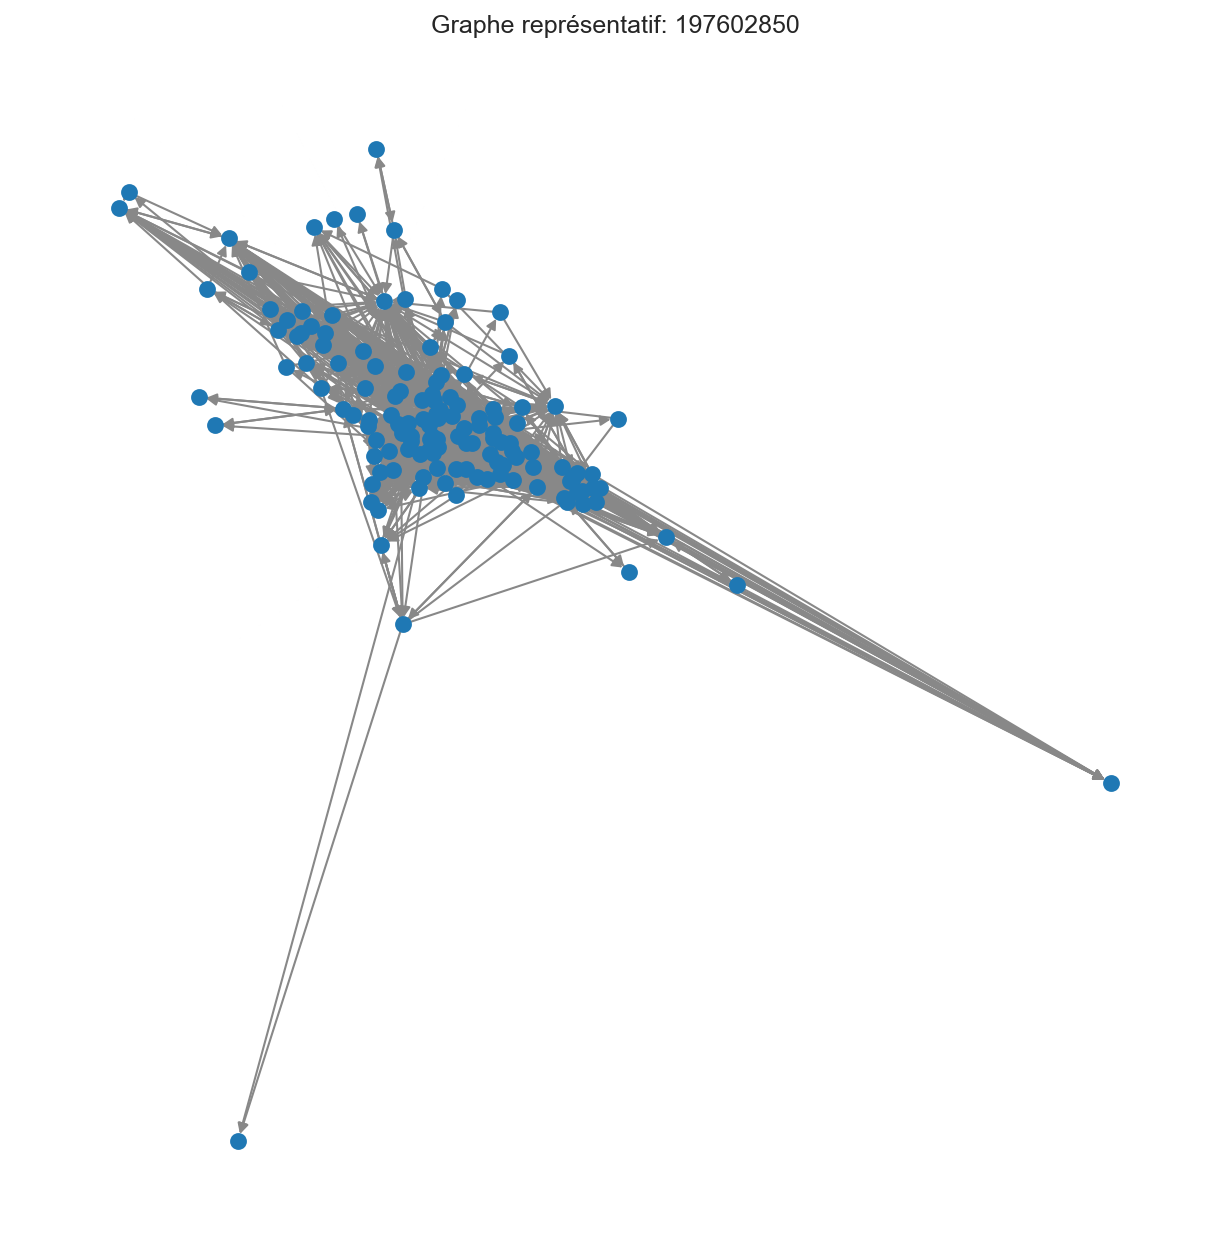

In [16]:
# Save and display the representative graph image
from IPython.display import display, Image
rep = globals().get('representative_net', None)
if rep is None:
    print('Aucun graphe représentatif sélectionné. Exécutez la cellule de sélection dabord.')
else:
    if 'graphs' not in globals() or rep not in graphs:
        print(f'Graphe {rep} introuvable dans la variable graphs.')
    else:
        Grep = graphs[rep]
        out_path = summary_dir / f'{rep}_graph.png'
        plt.figure(figsize=(8,8))
        pos = nx.spring_layout(Grep, seed=42)
        nx.draw(Grep, pos=pos, node_size=50, with_labels=False, edge_color='#888888')
        plt.title(f'Graphe représentatif: {rep}')
        plt.tight_layout()
        plt.savefig(out_path, dpi=150, bbox_inches='tight')
        plt.close()
        print('Graphe sauvegardé sous :', out_path)
        try:
            display(Image(filename=str(out_path)))
        except Exception:
            print('Impossible dafficher limage dans cet environnement; le fichier est sauvegardé.')

Graphe sauvegardé sous : betweenness.png


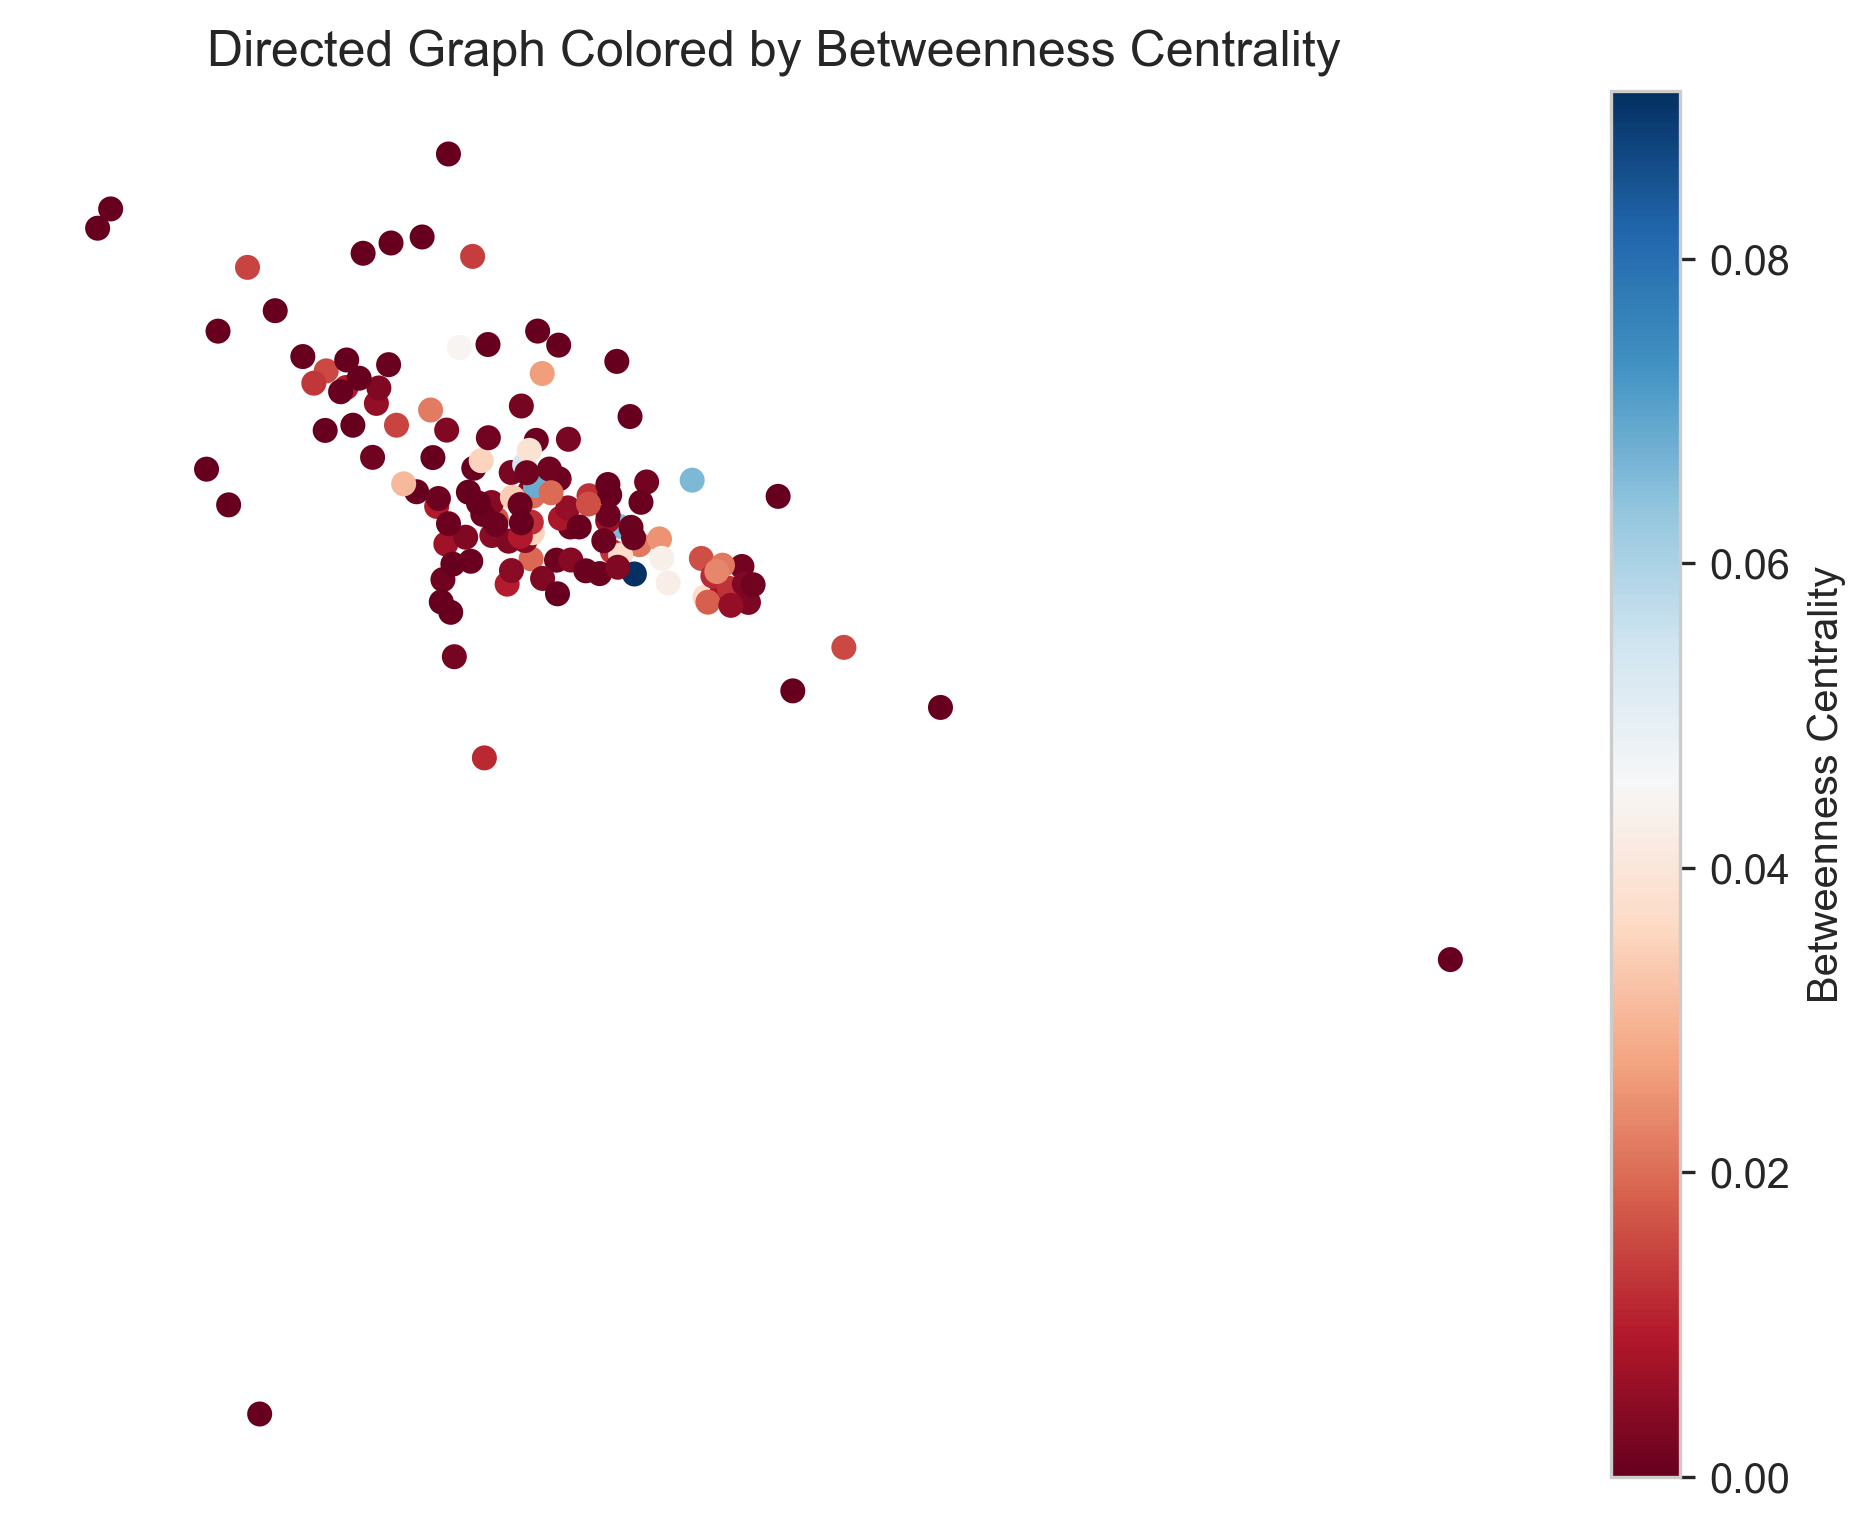

In [17]:
from IPython.display import display, Image

# 1. Compute betweenness centrality (directed)

rep = globals().get('representative_net', None)
G = graphs[rep]
out_path = 'betweenness.png'

betweenness = nx.betweenness_centrality(G, normalized=True)

# 2. Prepare node colors (least = red, greatest = blue)
values = list(betweenness.values())

# Layout for visualization
pos = nx.spring_layout(G, seed=42)

# 3. Draw graph
plt.figure(figsize=(8, 6))

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=25,
    node_color=values,
    cmap=plt.cm.RdBu,   # red → blue
    vmin=min(values),
    vmax=max(values)
)

# Colorbar
cbar = plt.colorbar(nodes)
cbar.set_label("Betweenness Centrality")

plt.title("Directed Graph Colored by Betweenness Centrality")
plt.axis("off")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close()
print('Graphe sauvegardé sous :', out_path)

display(Image(filename=str(out_path)))

Graphe sauvegardé sous : pagerank.png


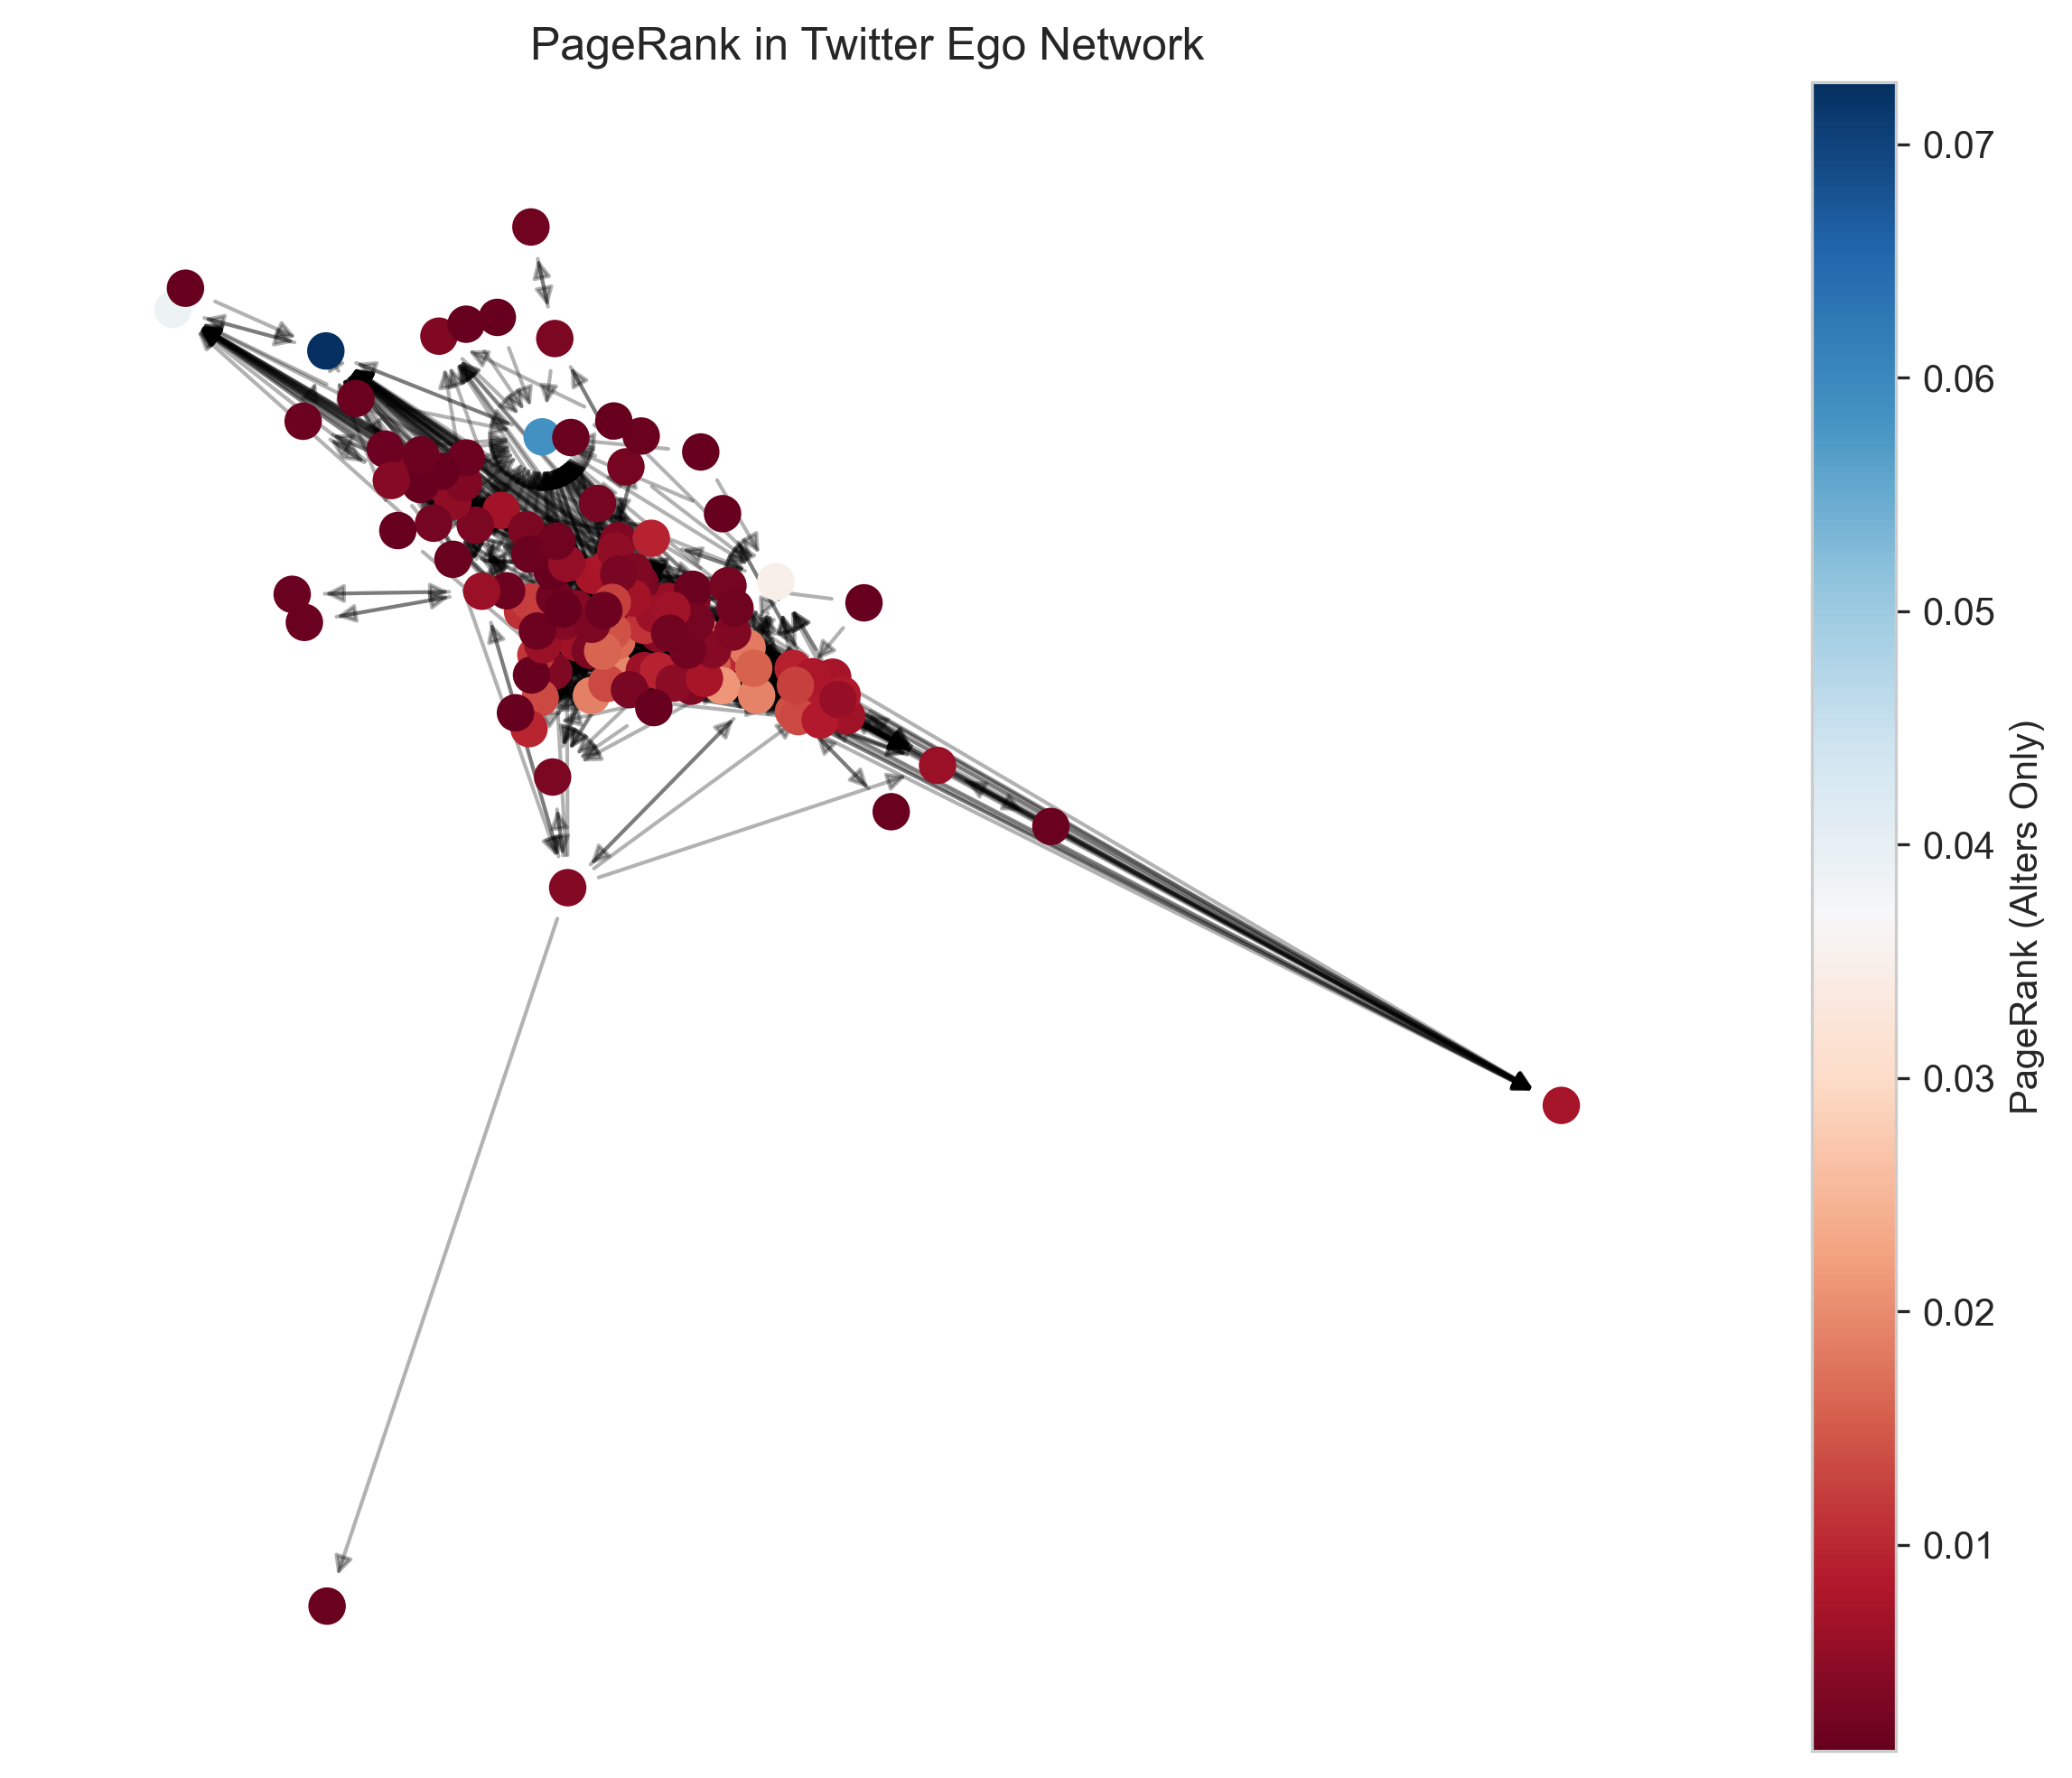

In [21]:
#page rank

import matplotlib.pyplot as plt

#remove ego from graph before doing page rank
ego = rep

G_no_ego = G.copy()
G_no_ego.remove_node(ego)

pagerank_alters = nx.pagerank(G_no_ego, alpha=0.85)

out_path = 'pagerank.png'


values = list(pagerank_alters.values())

pos = nx.spring_layout(G_no_ego, seed=42)

plt.figure(figsize=(10, 8))
nodes = nx.draw_networkx_nodes(
    G_no_ego,
    pos,
    node_color=values,
    cmap=plt.cm.RdBu,
    node_size=80
)

nx.draw_networkx_edges(G_no_ego, pos, alpha=0.3)
plt.colorbar(nodes, label="PageRank (Alters Only)")
plt.title("PageRank in Twitter Ego Network")
plt.axis("off")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close()
print('Graphe sauvegardé sous :', out_path)

display(Image(filename=str(out_path)))


Graphe sauvegardé sous : community.png


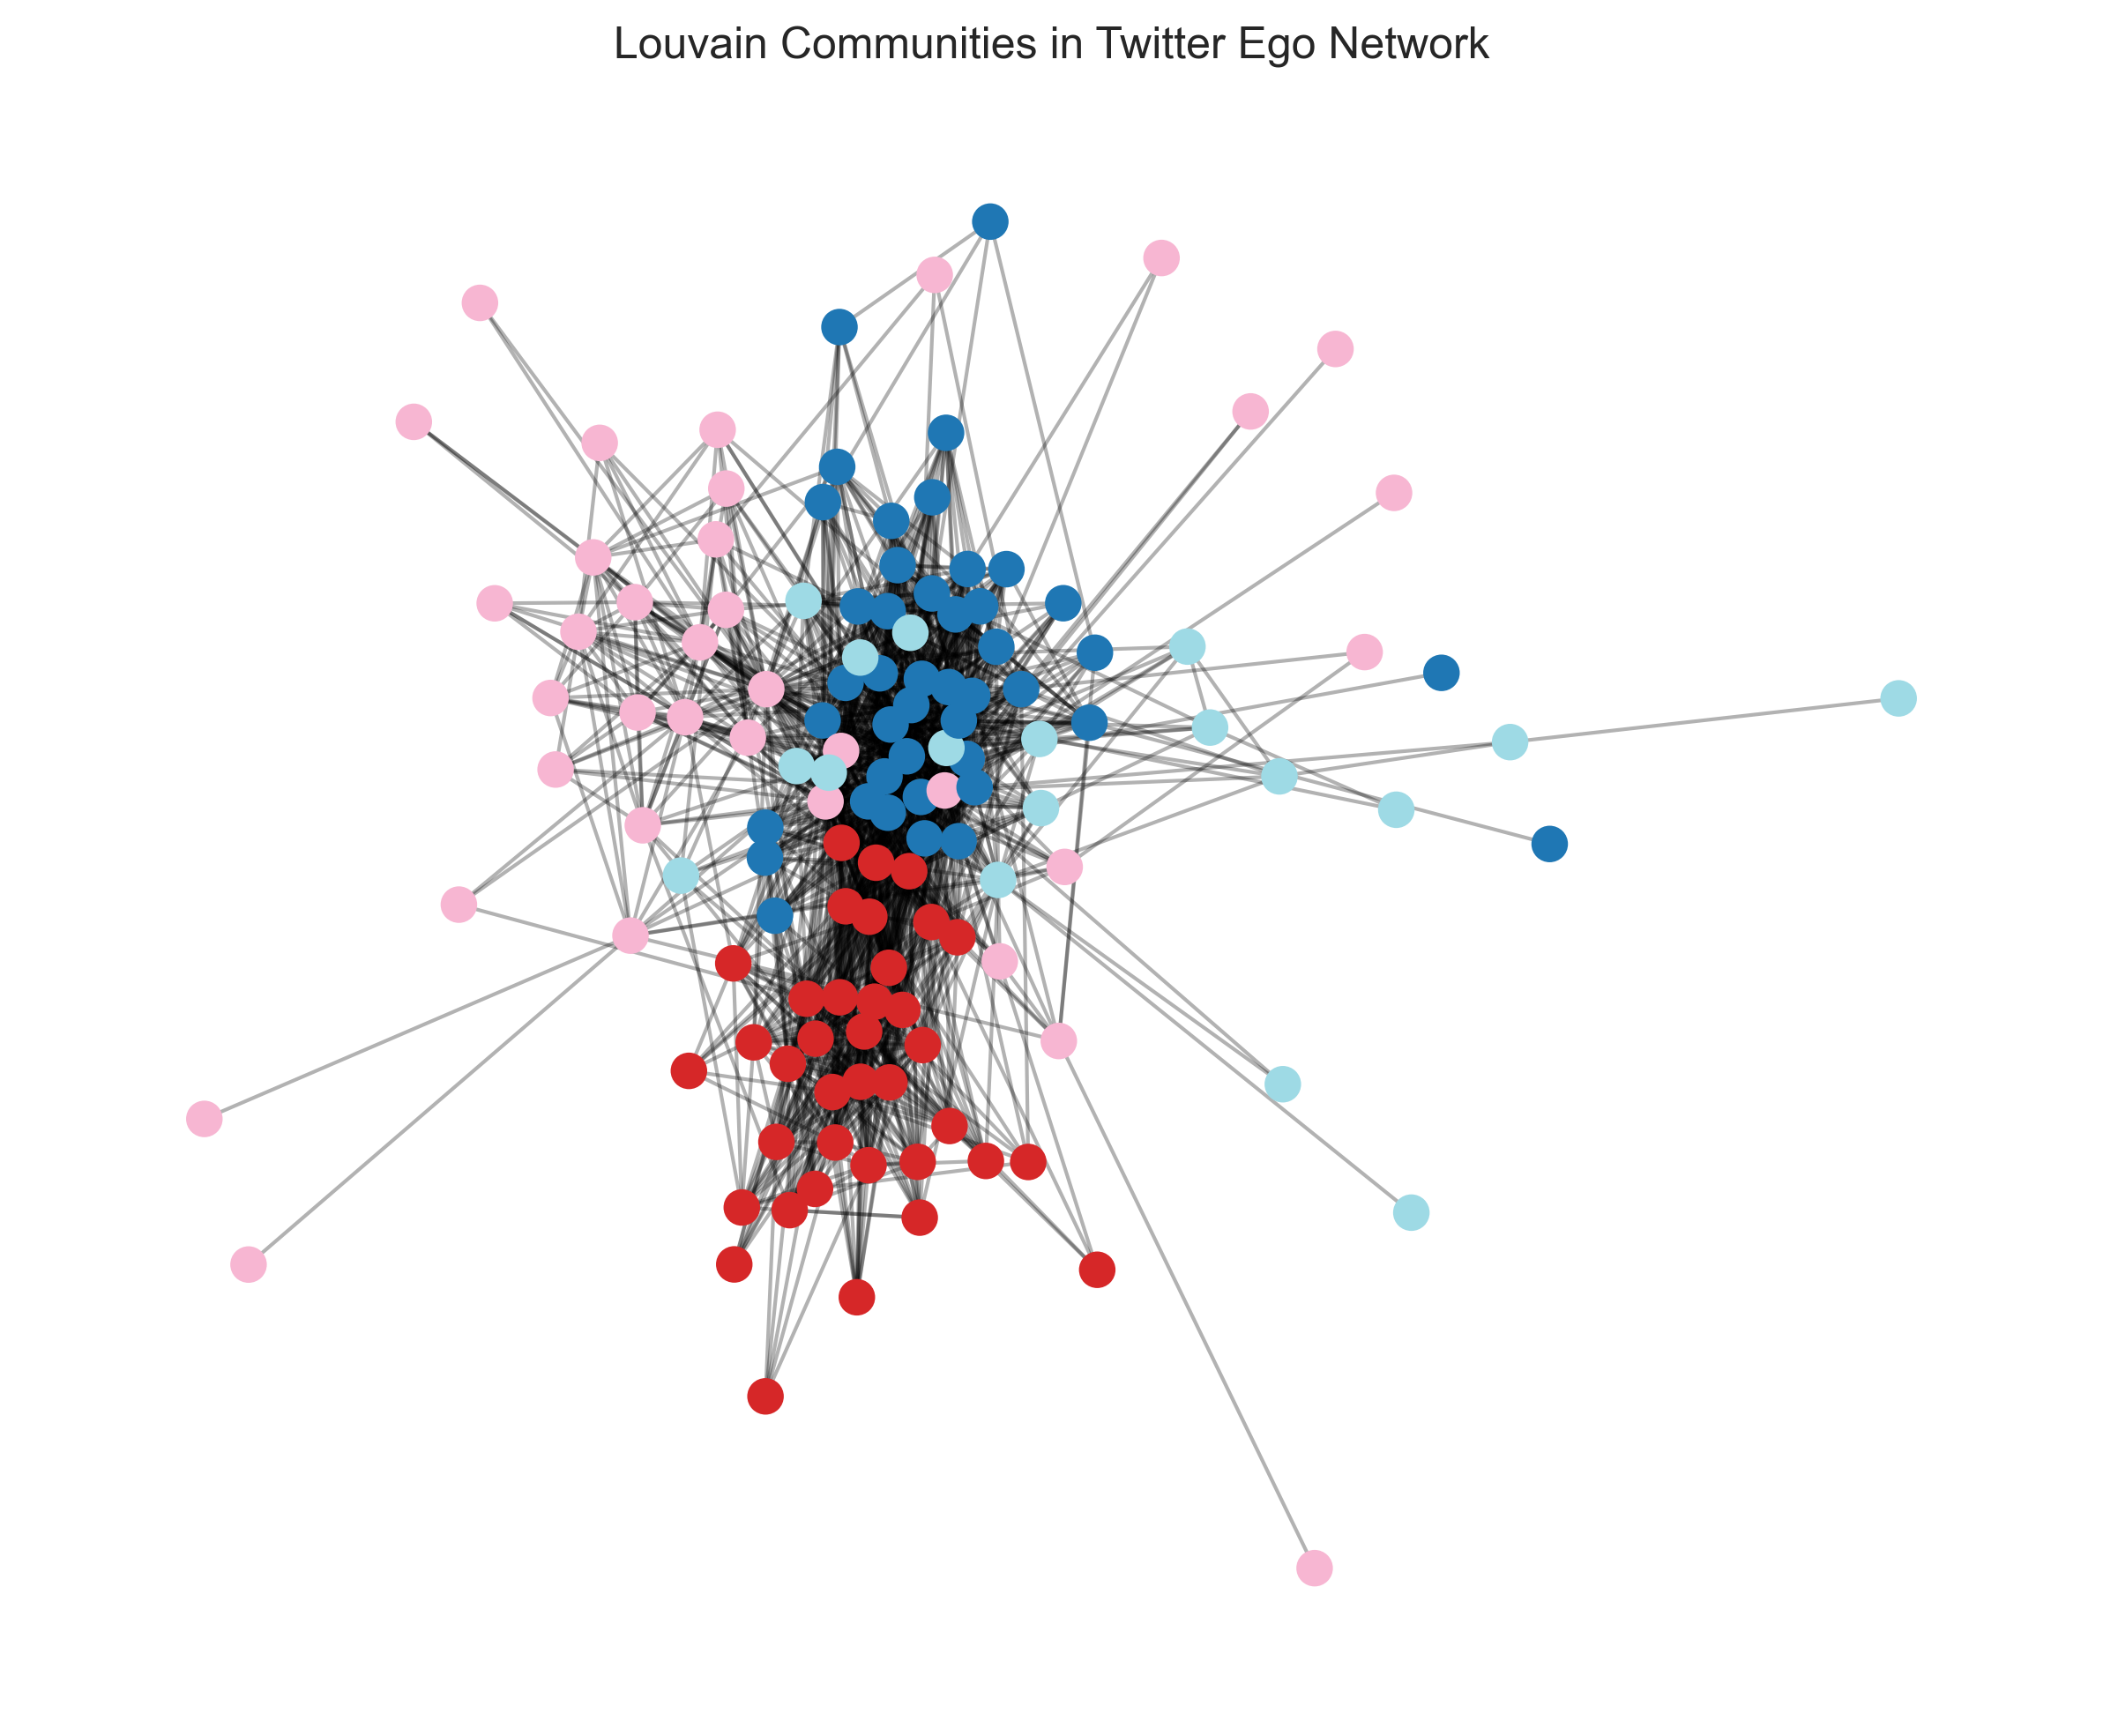

In [23]:
#louvain community detection
#only on undirected graph
import community.community_louvain as community_louvain

G_undirected = G_no_ego.to_undirected()
partition = community_louvain.best_partition(G_undirected)

# Get community labels
communities = list(partition.values())

pos = nx.spring_layout(G_undirected, seed=42)

plt.figure(figsize=(10, 8))

nodes = nx.draw_networkx_nodes(
    G_undirected,
    pos,
    node_color=communities,
    cmap=plt.cm.tab20,   # categorical colormap
    node_size=80
)

nx.draw_networkx_edges(G_undirected, pos, alpha=0.3)

out_path = 'community.png'

plt.title("Louvain Communities in Twitter Ego Network")
plt.axis("off")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close()
print('Graphe sauvegardé sous :', out_path)

display(Image(filename=str(out_path)))


## Final Summary

Print concise report and paths to saved CSVs.

In [19]:
print('='*80)
print('FINAL SUMMARY REPORT')
print('='*80)
print(f"Total ego networks analyzed: {len(ego_network_ids)}")
print(f"Summary CSVs and outputs saved to: {summary_dir}")
print('Saved files:')
for p in sorted(summary_dir.iterdir()):
    print(' -', p.name)
print('='*80)
print('Analysis complete')

FINAL SUMMARY REPORT
Total ego networks analyzed: 973
Summary CSVs and outputs saved to: twitter_ego/twitter/summary_tables
Saved files:
 - 197602850_graph.png
 - 197602850_node_embeddings.csv
 - atypical_top3.csv
 - basic_stats.csv
 - cluster_summary.csv
 - clustering_stats.csv
 - comprehensive_final.csv
 - comprehensive_metrics.csv
 - comprehensive_with_clusters.csv
 - correlation_heatmap.png
 - degree_stats.csv
 - network_rankings.csv
 - outliers.json
 - outliers_flat.csv
 - pca_coords.csv
 - prepared_197602850_nodes.csv
 - representative_network.csv
 - top_by_nodes.csv
 - typical_networks.csv
 - unusual_networks.csv
Analysis complete


In [20]:
from IPython.display import display, Markdown

rep = globals().get('representative_net', None)

if rep is None:
    display(Markdown("**Aucun graphe représentatif sélectionné. Exécutez la cellule de sélection d'abord.**"))
else:
    display(Markdown(f"## Résumé du graphe sélectionné : **{rep}**"))

    # Basic graph description
    if 'graphs' in globals() and rep in graphs:
        Gsel = graphs[rep]
        n_nodes = Gsel.number_of_nodes()
        n_edges = Gsel.number_of_edges()
        density = nx.density(Gsel)
        display(Markdown(f"- Nombre de nœuds : **{n_nodes}**"))
        display(Markdown(f"- Nombre d'arêtes : **{n_edges}**"))
        display(Markdown(f"- Densité : **{density:.4f}**"))
        if 'clustering_df' in globals() and rep in clustering_df.index:
            display(Markdown(f"- Clustering moyen : **{clustering_df.loc[rep,'avg_clustering']:.4f}**"))

    # Show prepared node features if available
    prep_path = summary_dir / f'prepared_{rep}_nodes.csv'
    if prep_path.exists():
        display(Markdown('### Extrait des features préparées (nœuds)'))
        try:
            dfp = pd.read_csv(prep_path, index_col=0)
            display(dfp.head())
        except Exception as e:
            display(Markdown(f'Erreur lecture {prep_path}: {e}'))
    else:
        display(Markdown('Fichier préparé des nœuds non trouvé.'))

    # Show embeddings if available
    emb_path = summary_dir / f'{rep}_node_embeddings.csv'
    if emb_path.exists():
        display(Markdown('### Extrait des embeddings de nœuds'))
        try:
            emdf = pd.read_csv(emb_path, index_col=0)
            display(emdf.head())
        except Exception as e:
            display(Markdown(f'Erreur lecture {emb_path}: {e}'))
    else:
        display(Markdown('Embeddings non trouvés (le GCN n\'a peut-être pas été exécuté).'))

    # GNN results summary
    if 'test_acc' in globals():
        display(Markdown('### Résultats GNN'))
        display(Markdown(f'- Accuracy (test) : **{test_acc:.3f}**'))
    else:
        display(Markdown('### Résultats GNN\n- Aucun résultat de test disponible (GCN non exécuté ou erreur).'))

    # Interpretation and next steps
    explanation = (
        """
**Interprétation (automatique)**

- Le graphe représentatif est choisi comme le réseau le plus proche de la moyenne des métriques (distance_from_mean minimale), il sert de cas typique.
- Le GCN a été entraîné sur des étiquettes synthétiques (bins de degré). Une accuracy élevée indique que la structure locale (degré, clustering) est discriminante pour cette tâche synthétique.
- Les embeddings de nœuds (si présents) peuvent être utilisés pour : clustering, réduction de dimension, visualisation ou tâches en aval.

**Prochaines étapes suggérées**

1. Vérifier/affiner les labels (utiliser des vraies étiquettes si disponibles).
2. Ajouter d'autres features nodales (attributs .feat ou egofeat) pour améliorer la prédiction.
3. Évaluer la robustesse (cross-validation, répétitions) et comparer plusieurs graphes sélectionnés (ex. atypiques vs représentatif).
4. Visualiser embeddings (UMAP / t-SNE) et examiner la séparation des classes.

"""
    )
    display(Markdown(explanation))


## Résumé du graphe sélectionné : **197602850**

- Nombre de nœuds : **135**

- Nombre d'arêtes : **2340**

- Densité : **0.1294**

- Clustering moyen : **0.6372**

### Extrait des features préparées (nœuds)

,deg_z,clust_z,label
17576144,1.281719,-0.382918,1
49273095,1.643819,-0.705498,1
6804822,0.350605,0.165129,1
22863357,0.247148,0.209596,1
143950772,0.091962,-1.301619,1


### Extrait des embeddings de nœuds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
17576144,0.881575,0.406197,0.354169,0.886791,0.179863,0.0,0.000000,1.141475,0.0,1.058580,0.000000,0.918077,1.055413,0.0,0.083065,0.000000
49273095,0.899383,0.412453,0.426627,0.892494,0.207469,0.0,0.000000,1.051273,0.0,1.084817,0.000000,0.865814,1.031009,0.0,0.172192,0.057207
6804822,0.998747,0.456849,0.513068,0.983749,0.244820,0.0,0.000000,1.099246,0.0,1.207590,0.000000,0.918849,1.117395,0.0,0.243852,0.107429
22863357,0.984771,0.449371,0.542222,0.963188,0.254733,0.0,0.000000,1.020846,0.0,1.193391,0.000000,0.866593,1.076318,0.0,0.289096,0.146508
143950772,0.000000,0.000000,0.222654,0.000000,0.080007,0.0,0.275146,0.000000,0.0,0.000000,0.338778,0.000000,0.000000,0.0,0.311740,0.262948


### Résultats GNN

- Accuracy (test) : **0.741**


**Interprétation (automatique)**

- Le graphe représentatif est choisi comme le réseau le plus proche de la moyenne des métriques (distance_from_mean minimale), il sert de cas typique.
- Le GCN a été entraîné sur des étiquettes synthétiques (bins de degré). Une accuracy élevée indique que la structure locale (degré, clustering) est discriminante pour cette tâche synthétique.
- Les embeddings de nœuds (si présents) peuvent être utilisés pour : clustering, réduction de dimension, visualisation ou tâches en aval.

**Prochaines étapes suggérées**

1. Vérifier/affiner les labels (utiliser des vraies étiquettes si disponibles).
2. Ajouter d'autres features nodales (attributs .feat ou egofeat) pour améliorer la prédiction.
3. Évaluer la robustesse (cross-validation, répétitions) et comparer plusieurs graphes sélectionnés (ex. atypiques vs représentatif).
4. Visualiser embeddings (UMAP / t-SNE) et examiner la séparation des classes.

